# First GAN

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

from utils.plot import show_tensor_images, show_loss_graph

## Generator

In [2]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            self.get_generator_block(z_dim, hidden_dim),
            self.get_generator_block(hidden_dim, hidden_dim * 2),
            self.get_generator_block(hidden_dim * 2, hidden_dim * 4),
            self.get_generator_block(hidden_dim * 4, hidden_dim * 8),

            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    
    def get_generator_block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim), # for stabilization 
            nn.ReLU(inplace=True),
        )

    def forward(self, noise):
        return self.gen(noise)


def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

## Discriminator

In [3]:
class Discriminator(nn.Module):

    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.get_discriminator_block(im_dim, hidden_dim * 4),
            self.get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            self.get_discriminator_block(hidden_dim * 2, hidden_dim),

            nn.Linear(hidden_dim, 1)
        )

    def get_discriminator_block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True) # to prevent "dying ReLU" problem
        )

    def forward(self, image):
        return self.disc(image)

## Config

In [4]:
n_epochs = 50

# Set parameters
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
batch_size = 128
lr = 0.00001

# Load MNIST dataset
dataloader = DataLoader(
    MNIST('./datasets', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cuda'

# Initialize generator and discriminator
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

## Training

In [ ]:
generator_loss_path = []
discriminator_loss_path = []
fake_path = []

tqdm_epochs = tqdm(range(n_epochs), unit="epoch")
for epoch in tqdm_epochs:
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        # Update discriminator
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # Update generator
        gen_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        # Keep track of the average losses
        discriminator_loss_path.append(disc_loss.item() / cur_batch_size)
        generator_loss_path.append(gen_loss.item() / cur_batch_size)

    # Keep track of generator fakes
    tqdm_epochs.set_postfix({"Generator loss": generator_loss_path[-1], "Discriminator loss": discriminator_loss_path[-1]})
    with torch.no_grad():
        fake_noise = get_noise(25, z_dim, device=device)
        fake_path.append(gen(fake_noise))


## Checkpoints

In [5]:
checkpoint_path = "./checkpoints/First_GAN.pt"

# Save
# torch.save({
#     "epoch": n_epochs,

#     "gen": gen.state_dict(),
#     "gen_opt": gen_opt.state_dict(),
#     "gen_loss_path": generator_loss_path,

#     "disc": disc.state_dict(),
#     "disc_opt": disc_opt.state_dict(),
#     "disc_loss_path": discriminator_loss_path,

#     "fake_path": fake_path
# }, checkpoint_path)

# Load
checkpoint = torch.load(checkpoint_path)
gen.load_state_dict(checkpoint["gen"])
disc.load_state_dict(checkpoint["disc"])
gen.eval()
disc.eval()

generator_loss_path = checkpoint["gen_loss_path"]
discriminator_loss_path = checkpoint["disc_loss_path"]
fake_path = checkpoint["fake_path"]

## Visualize Learning Path

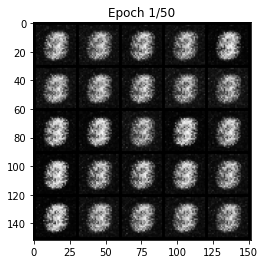

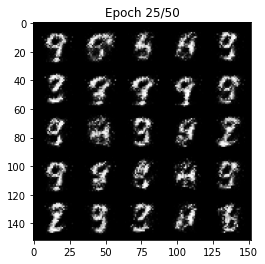

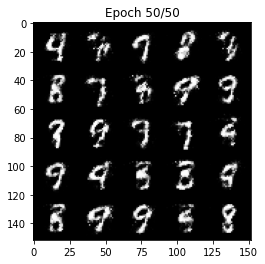

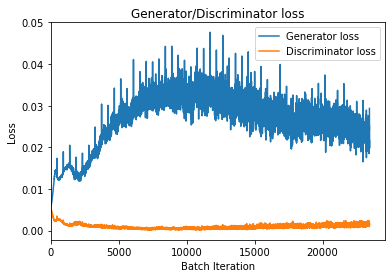

In [6]:
show_tensor_images(fake_path[0],    title=f"Epoch 1/{n_epochs}",            save_path="./figures/First_GAN_Epoch_01.pdf")
show_tensor_images(fake_path[24],   title=f"Epoch 25/{n_epochs}",           save_path="./figures/First_GAN_Epoch_25.pdf")
show_tensor_images(fake_path[-1],   title=f"Epoch {n_epochs}/{n_epochs}",   save_path="./figures/First_GAN_Epoch_50.pdf")

show_loss_graph(generator_loss_path, discriminator_loss_path, title="Generator/Discriminator loss", save_path="./figures/First_GAN_Loss.pdf")

## Conclusion

From the **Epoch x/50** plots we can observe how learning progresses over time. We can also observe phenomen called mode collapse, this means that generator is more prone to generate certian numbers, in our case 8 and 9.

From the **Generator/Discriminator loss** plot we can not directly compare loss values between the generator and the discriminator, but we can observe that discriminator's job is much easier compared to the generator.


## Cleanup

In [7]:
%reset